# Imports

In [1]:
# Importing Libraries

In [2]:
!pip install json-tricks

In [3]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from sklearn.metrics import precision_recall_fscore_support
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import StratifiedShuffleSplit


import numpy as np
import os
from json_tricks import dump, load

#from pydub import AudioSegment, effects
import librosa
#import noisereduce as nr

import tensorflow as tf
import keras
import sklearn

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import time
tic = time.perf_counter()

from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras import callbacks


# ensemble


# Dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/sample/"
#Crema = "/content/drive/MyDrive/datasets/speech/CREMAD/AudioWAV/"
Ravdess = "/content/drive/MyDrive/datasets/speech/RAVDESS/data"
Ravdess_processed = "/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/"
Ravdess_speech_sample = "/content/drive/MyDrive/datasets/speech/RAVDESS/data/Audio_Speech_Actors_01-24/"

In [6]:
##Hypter Parameters' Range
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 300,
    "lr": 0.00010000,
    "time_steps": 60
}
#TIME_STEPS = params["time_steps"]
#BATCH_SIZE = params["batch_size"]
#iter_changes = "dropout_layers_0.4_0.4"


# Load Processed Files, Construct Train, Validation and Test Sets

In [8]:

processed_path = Ravdess_processed
x_path = processed_path + "X_datanew.json" # FILE LOAD PATH
y_path =  processed_path + "Y_datanew.json" # FILE SAVE PATH
#x_path = '/content/drive/MyDrive/datasets/speech/RAVDESS/processedData/X_datanew.json'

# Load X,Y json files back into lists, convert to np.arrays

X = load(x_path)
X = np.asarray(X, dtype = 'float32')

Y = load(y_path)
Y = np.asarray(Y, dtype = 'int8')

In [9]:
# Split to train, validation, and test sets.
from sklearn.model_selection import train_test_split
x_train, x_tosplit, y_train, y_tosplit = train_test_split(X, Y, test_size = 0.125, random_state = 1)
x_val, x_test, y_val, y_test = train_test_split(x_tosplit, y_tosplit, test_size = 0.304, random_state = 1)

#'One-hot' vectors for Y: emotion classification
y_train_class = tf.keras.utils.to_categorical(y_train, 8, dtype = 'int8')
y_val_class = tf.keras.utils.to_categorical(y_val, 8, dtype = 'int8')

In [10]:
# x_train, x_val, and x_test shape check.
print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(2145, 523, 15)
(213, 523, 15)
(94, 523, 15)


In [11]:
# Save x_test, y_test to JSON.

x_test_path = processed_path + 'x_test_data.json'
dump(obj = x_test, fp = x_test_path)

y_test_path = processed_path + 'y_test_data.json'
dump(obj = y_test, fp = y_test_path)

'{"__ndarray__": [[4], [3], [3], [3], [2], [4], [4], [1], [3], [0], [3], [5], [2], [6], [0], [3], [2], [5], [5], [3], [7], [1], [5], [0], [2], [7], [0], [4], [3], [3], [2], [4], [2], [5], [6], [5], [5], [4], [5], [3], [7], [4], [3], [2], [4], [0], [1], [2], [6], [1], [3], [4], [5], [6], [7], [6], [3], [4], [5], [7], [4], [4], [7], [3], [1], [0], [4], [1], [3], [4], [1], [0], [4], [4], [1], [2], [2], [6], [3], [5], [3], [3], [3], [5], [5], [5], [6], [4], [2], [6], [2], [4], [3], [1]], "dtype": "int8", "shape": [94, 1], "Corder": true}'

# Model

RNN Model

## Define Model & Training

In [12]:
# Initializing the model

model = Sequential()
model.add(layers.LSTM(64, return_sequences = True, input_shape=(X.shape[1:3])))
model.add(layers.LSTM(64))
model.add(layers.Dense(8, activation = 'softmax'))
print(model.summary())

batch_size = 23

# Callbacks functions
checkpoint_path = Ravdess + "/model/best_weights-2.hdf5"

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)
                             
# Compile & train   
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

history = model.fit(x_train, y_train_class, 
                      epochs=340, batch_size = batch_size, 
                      validation_data = (x_val, y_val_class), 
                      callbacks = [mcp_save, rlrop])
# Define the best weights to the model.
model.load_weights(checkpoint_path)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 523, 64)           20480     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
Total params: 54,024
Trainable params: 54,024
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/340
94/94 [==============================] - 53s 519ms/step - loss: 2.0371 - categorical_accuracy: 0.1851 - val_loss: 2.0013 - val_categorical_accuracy: 0.1549 - lr: 0.0010
Epoch 2/340
94/94 [==============================] - 48s 510ms/step - loss: 2.0161 - categorical_accuracy: 0.1977 - val_loss: 2.02

## Loading Model

In [13]:
  
#history = model.fit(x_t, y_t, epochs = 30, verbose=2, batch_size=BATCH_SIZE,
#                    shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
#                    trim_dataset(y_val, BATCH_SIZE)), callbacks=[es])


In [14]:
model.load_weights(checkpoint_path)

# Evaluation

In [15]:
#test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
#print("Test Accuracy: ",test_acc)

In [16]:
model.save('Speech-Emotion-Recognition-Model-RNN-1.h5')

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt 

## Train (fit) Visualization

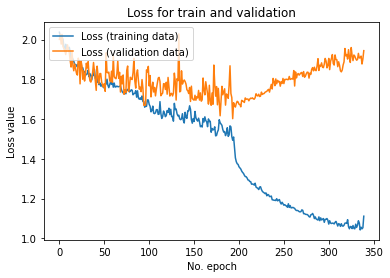

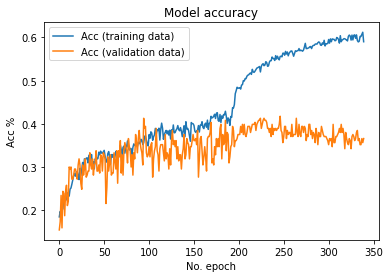

In [18]:
# Loss, Accuracy presentation

# Plot history: Loss
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for train and validation')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

#Plot history: Accuracy
plt.plot(history.history['categorical_accuracy'], label='Acc (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='Acc (validation data)')
plt.title('Model accuracy')
plt.ylabel('Acc %')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

## Validation Set Evaluation

### Val Set Score

In [35]:
# Validation score
#loss,acc = model.evaluate(x_val, y_val_class, verbose=2)


### Val Set Confussion Matrix

Text(0.5, 51.0, 'Predicted emotion')

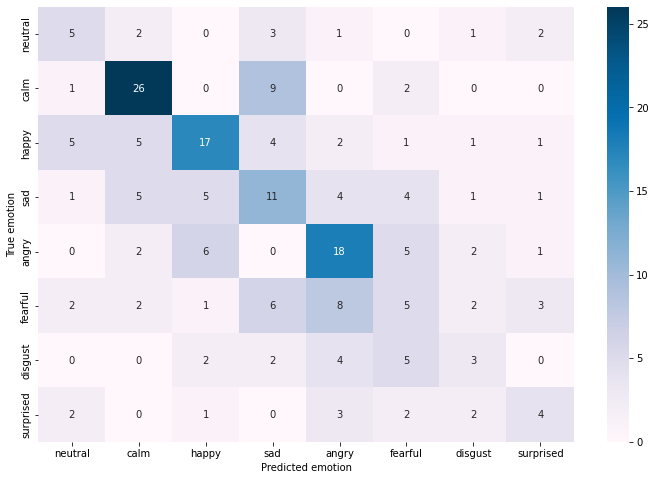

In [20]:
# Validation Confusion matrix

y_val_class = np.argmax(y_val_class, axis=1)
predictions = model.predict(x_val)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_val_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'PuBu', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

### Validation Set Predicted emotions accuracy

In [21]:
# Validation set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Validation set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Validation set predicted emotions accuracy:
neutral : 0.3571
calm : 0.6842
happy : 0.4722
sad : 0.3438
angry : 0.5294
fearful : 0.1724
disgust : 0.1875
surprised : 0.2857


In [23]:
# Validation set precision, recall, fscore

precision_recall_fscore_support(y_val_class, y_pred_class, average='macro')
precision_recall_fscore_support(y_val_class, y_pred_class, average='weighted')

(0.4088698859825621, 0.41784037558685444, 0.4113738579495101, None)

## Save & Load model, weights

In [24]:
# Saving model & weights

from keras.models import model_from_json
from keras.models import load_model
model_path = Ravdess + "/model/"
model_json = model.to_json()
saved_model_path = model_path + 'model8723-2.json'
saved_weights_path = model_path + 'model8723_weights-2.h5'


with open(saved_model_path, "w") as json_file:
    json_file.write(model_json)
    
model.save_weights(saved_weights_path)
print("Saved model to disk")

Saved model to disk


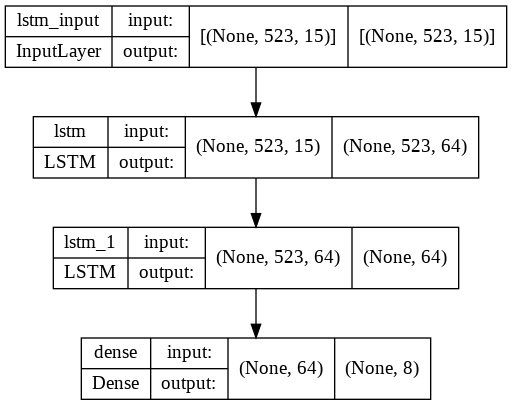

In [25]:
# Reading the model from JSON file
#model_path = Ravdess + "/model/"
#saved_model_path = model_path + 'model8723.json'
#saved_weights_path = model_path + 'model8723_weights.h5'


with open(saved_model_path , 'r') as json_file:
    json_savedModel = json_file.read()
    
# Loading the model architecture, weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights(saved_weights_path)

# Compiling the model with similar parameters as the original model.
model.compile(loss='categorical_crossentropy', 
                optimizer='RMSProp', 
                metrics=['categorical_accuracy'])

# Model's structure visualization
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [26]:
# Loading x_test, y_test json files, and converting to np.arrays

x_test = load(processed_path + 'x_test_data.json')
x_test = np.asarray(x_test).astype('float32')

y_test = load( processed_path + 'y_test_data.json')
y_test = np.asarray(y_test).astype('int8')

y_test_class = tf.keras.utils.to_categorical(y_test, 8, dtype = 'int8')

## Test Set Evaluation

### Test Set Score



In [27]:
#loss, acc = model.evaluate(x_test, y_test_class, verbose=2)

### Test Set Confussion Matrix

Text(0.5, 51.0, 'Predicted emotion')

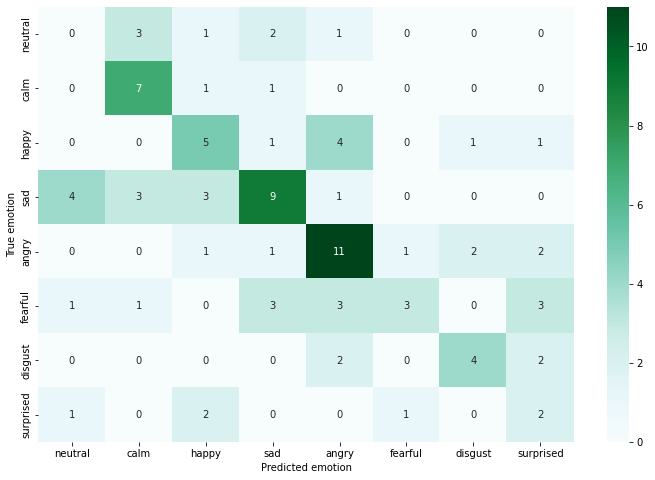

In [28]:
# Test set Confusion matrix

y_test_class = np.argmax(y_test_class, axis=1)
predictions = model.predict(x_test)
y_pred_class = np.argmax(predictions, axis=1)

cm=confusion_matrix(y_test_class, y_pred_class)

index = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
columns = ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']  
 
cm_df = pd.DataFrame(cm,index,columns)                      
plt.figure(figsize=(12,8))
ax = plt.axes()

sns.heatmap(cm_df, ax = ax, cmap = 'BuGn', fmt="d", annot=True)
ax.set_ylabel('True emotion')
ax.set_xlabel('Predicted emotion')

### Test Set Predicted emotions accuracy

In [29]:
# Test set prediction accuracy rates

values = cm.diagonal()
row_sum = np.sum(cm,axis=1)
acc = values / row_sum

print('Test set predicted emotions accuracy:')
for e in range(0, len(values)):
    print(index[e],':', f"{(acc[e]):0.4f}")

Test set predicted emotions accuracy:
neutral : 0.0000
calm : 0.7778
happy : 0.4167
sad : 0.4500
angry : 0.6111
fearful : 0.2143
disgust : 0.5000
surprised : 0.3333


In [31]:
# Validation set precision, recall, fscore

precision_recall_fscore_support(y_test_class, y_pred_class, average='macro')
precision_recall_fscore_support(y_test_class, y_pred_class, average='weighted')

(0.456117537031179, 0.43617021276595747, 0.42655010529298465, None)

In [33]:
y_test_class

array([4, 3, 3, 3, 2, 4, 4, 1, 3, 0, 3, 5, 2, 6, 0, 3, 2, 5, 5, 3, 7, 1,
       5, 0, 2, 7, 0, 4, 3, 3, 2, 4, 2, 5, 6, 5, 5, 4, 5, 3, 7, 4, 3, 2,
       4, 0, 1, 2, 6, 1, 3, 4, 5, 6, 7, 6, 3, 4, 5, 7, 4, 4, 7, 3, 1, 0,
       4, 1, 3, 4, 1, 0, 4, 4, 1, 2, 2, 6, 3, 5, 3, 3, 3, 5, 5, 5, 6, 4,
       2, 6, 2, 4, 3, 1])

In [32]:
y_pred_class

array([4, 0, 4, 3, 4, 5, 4, 1, 0, 1, 3, 3, 2, 6, 1, 3, 3, 3, 1, 0, 7, 3,
       7, 1, 4, 2, 4, 4, 3, 1, 2, 3, 7, 5, 4, 4, 0, 4, 4, 2, 7, 4, 3, 6,
       4, 2, 1, 2, 4, 1, 0, 7, 3, 7, 2, 6, 1, 4, 5, 5, 4, 2, 0, 2, 1, 3,
       4, 1, 2, 4, 1, 3, 4, 6, 1, 2, 4, 7, 1, 7, 3, 3, 3, 7, 5, 4, 6, 6,
       4, 6, 2, 7, 3, 2])